In [387]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#This is shit check how to import well
sys.path.insert(1, '/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering/Code/utilities')
import cwt , clusters
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.cluster import KMeans

In [388]:
n_samples = 200
sampling_rate = 50
def gen_signal1(samples):
    signal1 = np.sin(samples * np.pi  +5) +np.cos(samples * np.pi)
    return signal1
def gen_signal2(samples):
    signal2 = np.sin(samples * np.pi * 2) 
    return signal2
def gen_signal3(samples):
    signal3 = np.sin(samples * np.pi + 4) 
    return signal3
def add_noise(signal, start, end, sampling_rate):
    t = np.linspace(0, len(signal)/ sampling_rate, len(signal))
    signal[start: end] += np.sin(t * np.pi *20)[start:end]


t = np.linspace(0, n_samples / sampling_rate, int(n_samples), endpoint=False)

signal1 = gen_signal1(t)
signal2 = gen_signal2(t)
signal3 = gen_signal3(t)

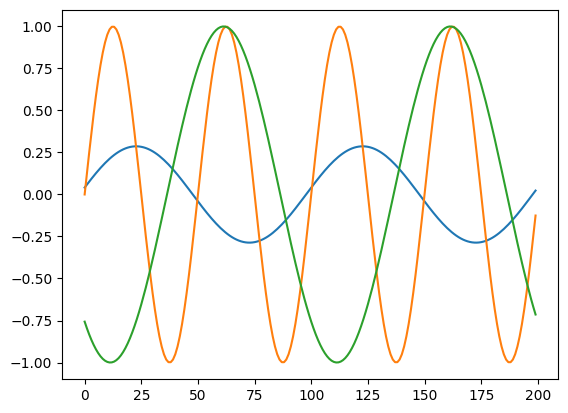

In [389]:
plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

In [392]:

channel_spacing = 8
#inverse of speed i.e. 1000 m/s
slowness = 0.001
n_channels = 100

#The actual signal meassured by DAS 
strain_rate = torch.tensor(signal1 + signal2 + signal3)



synthetic_DAS = torch.zeros(n_channels, len(strain_rate))

shift = channel_spacing * sampling_rate* slowness
synthetic_DAS = torch.zeros((n_channels, n_samples))
noise = np.zeros((n_channels, n_samples))
base_noise = np.zeros(n_samples)
add_noise(base_noise, 0,-1, sampling_rate)
base_noise = torch.tensor(base_noise)
for i in range(noise.shape[0]):
    noise[i] = torch.roll(base_noise, int(i*shift))


for i in range(n_channels):
    synthetic_DAS[i] = torch.roll(strain_rate, int(i*shift))
noise_start_channel= 0
noise_start_sample = 0
synthetic_DAS[noise_start_channel: noise_start_channel+noise.shape[0], noise_start_sample: noise_start_sample+noise.shape[1]] += noise

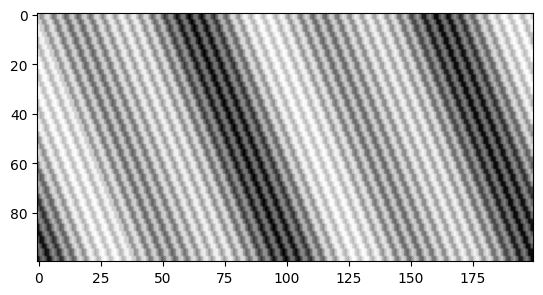

In [393]:
plt.imshow(synthetic_DAS, cmap="Greys")

In [377]:
dj = 0.5 
w0 = 8
minSpaceFrq = 0.002
maxSpaceFrq = 0.12
nf = 30
scales = cwt.get_scales(1/sampling_rate, dj, w0=8, n_samples=n_samples)
space_log = np.logspace(np.log10(minSpaceFrq), np.log10(maxSpaceFrq), nf)
transform = cwt.transform_window(synthetic_DAS, n_channels, sampling_rate, samples_per_subSample=1, space_log= space_log, time_scales= scales, subsampling=False, derivative=False)

n_features = transform.shape[2]

/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering/Code/utilities/cwt.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_derivative = torch.tensor(data, dtype=torch.float32)


torch.Size([100, 200, 55])


Compute Statistics About clusters for different k 

In [378]:
features = np.reshape(transform, (n_channels * n_samples, -1))
features.shape
for i in range(2,11):
    n_clusters = i
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(features)
    stats = clusters.evaluate_cluster(features, kmeans.labels_)
    print(f'stats for k={i} is {stats}')


stats for k=2 is {'sillhouette_score': 0.38097426, 'CH_score': 15909.757723754288, 'DB_score': 1.0385694239801537}
stats for k=3 is {'sillhouette_score': 0.35763758, 'CH_score': 13749.190158493406, 'DB_score': 1.0309560027937172}
stats for k=4 is {'sillhouette_score': 0.2864178, 'CH_score': 12255.244211426514, 'DB_score': 1.2102430053642537}
stats for k=5 is {'sillhouette_score': 0.29433414, 'CH_score': 11859.182530322798, 'DB_score': 1.1000160839236612}
stats for k=6 is {'sillhouette_score': 0.24589986, 'CH_score': 10773.784646372858, 'DB_score': 1.2639271220356427}
stats for k=7 is {'sillhouette_score': 0.24475323, 'CH_score': 10064.064129043842, 'DB_score': 1.3063162388241436}
stats for k=8 is {'sillhouette_score': 0.26463643, 'CH_score': 9556.500580991938, 'DB_score': 1.1375664951764062}
stats for k=9 is {'sillhouette_score': 0.25138327, 'CH_score': 9037.80355643431, 'DB_score': 1.2590629183643}
stats for k=10 is {'sillhouette_score': 0.23470312, 'CH_score': 8720.82695393766, 'DB_s

In [379]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(features)
trainingLabels = np.reshape(kmeans.labels_, (n_channels, -1))


Text(0.5, 1.0, 'Cluster frequency of cluster 0 across Channels')

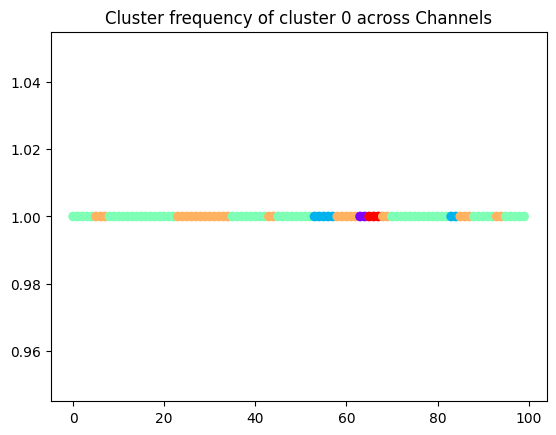

In [380]:
counts = np.zeros(n_channels)
label = 0
counts = np.sum(trainingLabels == label, axis=1)
normed_counts = counts/ np.max(counts)

x = np.asarray([i for i in range(n_channels)])
y = np.ones(n_channels)

plt.scatter(x, y, c = normed_counts, cmap='rainbow')   
plt.title(f'Cluster frequency of cluster {label} across Channels')

    

Autoencoder Test

In [381]:

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, encoding_dim)
        )
        ## decoder ##
        self.decoder =   self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32,input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = F.relu(self.encoder(x))
        # pass out into decoder
        out = self.decoder(out)
        
        return out
    
    def encode(self, x ):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        return self.encoder(x)

# initialize the NN
encoding_dim = 6
model = Autoencoder(encoding_dim, n_features)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=55, out_features=32, bias=True)
    (1): ReLU()
    (2): Tanh()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Tanh()
    (5): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=55, bias=True)
    (5): Sigmoid()
  )
)


In [382]:
print(features.shape)
batched_data = np.reshape(features, (-1, 20, n_features))
print(batched_data.shape)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in batched_data:
        images = torch.tensor(data, dtype=torch.float32)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(batched_data)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

torch.Size([20000, 55])
torch.Size([1000, 20, 55])


/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_1760/540811142.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(data, dtype=torch.float32)


Epoch: 1 	Training Loss: 5.818817
Epoch: 2 	Training Loss: 5.424930
Epoch: 3 	Training Loss: 5.376800
Epoch: 4 	Training Loss: 5.344219
Epoch: 5 	Training Loss: 5.329101
Epoch: 6 	Training Loss: 5.330994
Epoch: 7 	Training Loss: 5.331401
Epoch: 8 	Training Loss: 5.318895
Epoch: 9 	Training Loss: 5.321920
Epoch: 10 	Training Loss: 5.325208
Epoch: 11 	Training Loss: 5.322567
Epoch: 12 	Training Loss: 5.323129
Epoch: 13 	Training Loss: 5.316526
Epoch: 14 	Training Loss: 5.316168
Epoch: 15 	Training Loss: 5.322324
Epoch: 16 	Training Loss: 5.325817
Epoch: 17 	Training Loss: 5.309544
Epoch: 18 	Training Loss: 5.310979
Epoch: 19 	Training Loss: 5.319993
Epoch: 20 	Training Loss: 5.323215
Epoch: 21 	Training Loss: 5.334139
Epoch: 22 	Training Loss: 5.324411
Epoch: 23 	Training Loss: 5.308444
Epoch: 24 	Training Loss: 5.320857
Epoch: 25 	Training Loss: 5.318663
Epoch: 26 	Training Loss: 5.318125
Epoch: 27 	Training Loss: 5.317069
Epoch: 28 	Training Loss: 5.312845
Epoch: 29 	Training Loss: 5.3

In [383]:
encoded_features = model.encode(features).detach().numpy()
print(encoded_features.shape)


for i in range(2,11):
    n_clusters = i
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(encoded_features)
    stats = clusters.evaluate_cluster(encoded_features, kmeans.labels_)
    print(f'stats for k={i} is {stats}')

(20000, 6)
stats for k=2 is {'sillhouette_score': 0.3368326, 'CH_score': 11171.211167854693, 'DB_score': 1.2930764143338078}
stats for k=3 is {'sillhouette_score': 0.322776, 'CH_score': 9169.660744082754, 'DB_score': 1.2855237075922805}
stats for k=4 is {'sillhouette_score': 0.32300702, 'CH_score': 9332.897170407698, 'DB_score': 1.260865087214531}
stats for k=5 is {'sillhouette_score': 0.36554793, 'CH_score': 10082.54871804309, 'DB_score': 1.1047806203053063}
stats for k=6 is {'sillhouette_score': 0.38202465, 'CH_score': 9751.007009108473, 'DB_score': 1.0268219589201764}
stats for k=7 is {'sillhouette_score': 0.37689352, 'CH_score': 9579.040637788798, 'DB_score': 1.044128149336699}
stats for k=8 is {'sillhouette_score': 0.38569692, 'CH_score': 9456.502562164596, 'DB_score': 0.9624229632090339}
stats for k=9 is {'sillhouette_score': 0.39197874, 'CH_score': 9485.253007207313, 'DB_score': 0.9704078972515541}
stats for k=10 is {'sillhouette_score': 0.39917085, 'CH_score': 9478.484444505124

In [384]:
n_clusters= 10

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(encoded_features)


KMeans(n_clusters=10, n_init=10)

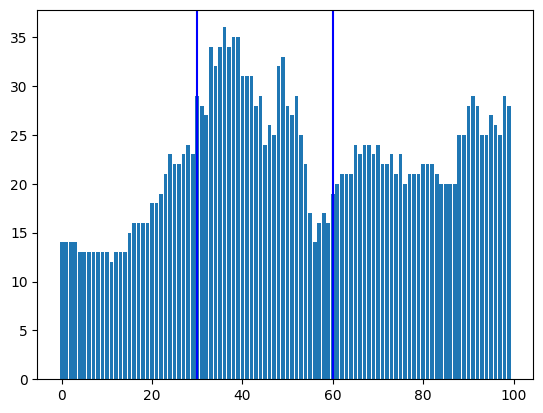

In [385]:
trainingLabels= np.reshape(kmeans.labels_,(n_channels, -1))
counts = np.zeros(n_channels)
label = 3
counts = np.sum(trainingLabels == label, axis=1)
normed_counts = counts/ np.max(counts)
x = np.asarray([i for i in range(n_channels)])
y = np.ones(n_channels)
plt.bar(x, counts)
plt.axvline(x=noise_start_channel, color='b', linestyle='-')
plt.axvline(x=noise_start_channel + noise.shape[0], color='b', linestyle='-')

Inverse CWT of Reconstruction